In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import os

tf.random.set_seed(42) # for reproducibility


# Practical session 10: Deep Learning

<div class="alert alert-block alert-info">
    <h2>Table of Contents </h2><a class="anchor" id="top"></a>
    <br><a href="#section_1">1. Data loading</a>
    <br><a href="#section_2">2. Preprocessing the dataset</a>
    <br><a href="#section_3">3. Implementing a neural network</a>
    <br>&nbsp;&nbsp;&nbsp;&nbsp;<a href="#section_3_1">3.1 Define the architecture</a>
    <br>&nbsp;&nbsp;&nbsp;&nbsp;<a href="#section_3_2">3.2 Define the loss function, optimizer, and metrics</a>
    <br>&nbsp;&nbsp;&nbsp;&nbsp;<a href="#section_3_3">3.3 Run the learning procedure to train the network</a>
    <br>&nbsp;&nbsp;&nbsp;&nbsp;<a href="#section_3_4">3.4 Inspect classifier performance</a>
    <br><a href="#section_4">Extra: A look at intermediate representations of the network</a>
</div>


## Malaria cell classification

Malaria is a blood disease caused by the *Plasmodium* parasite, and is transmitted through the bite of the female *Anopheles* mosquito. The disease is mostly diagnosed by counting parasitized blood cells in a blood smear under a microscope. However, manual cell counting is an exhausting, error-prone procedure. This can negatively affect the quality of the diagnosis [[1]](https://peerj.com/articles/4568/). Especially in *resource-constrained* regions of the world, difficult working conditions lead to poor diagnosis quality [[2]](https://lhncbc.nlm.nih.gov/publication/pub9932) .

In this practical session we will develop a deep learning pipeline that will aid in improving malaria diagnosis by automating infected cell counting. To this end we will use the Malaria cell dataset [[2]](https://lhncbc.nlm.nih.gov/publication/pub9932) to train a neural network that predicts a cell's infection state based on a microscopy image of it. The microscopy images were acquired using a smartphone attached to a small portable microscope.

To set up the deep learning pipeline we will go through these steps:
- Load the dataset
-  Preprocess the dataset
-  Define a neural network
-  Define the learning procedure
-  Train the neural network
- Inspect the network's performance

We will use the [TensorFlow machine learning framework](http://tensorflow.org) to implement these steps.

<h2 style="display: inline">1. Data loading</h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_1"></a> 

### Device setup

In [3]:
from tensorflow.python.client import device_lib

def select_device(prefer_gpu=True):
    local_device_protos = device_lib.list_local_devices()
    gpus = [x.name for x in local_device_protos if x.device_type == 'GPU']
    if (len(gpus) > 0) and prefer_gpu:
        return gpus[0]
    else:
        return [x.name for x in local_device_protos if x.device_type == 'CPU'][0]

In [4]:
# This code sets the device to use to GPU if you have one available
device = select_device(prefer_gpu=True)
device

2023-05-02 14:06:30.392068: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 14:06:30.428912: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-02 14:06:30.521522: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-02 14:06:30.521653: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative val

'/device:GPU:0'

The above `device` is used in the notebook to select where code is executed. This is done with a `with` statement:

```
with tf.device(device):
    # code
```

### Load the Malaria dataset

We use the `tensorflow-datasets` package to load the malaria dataset.

In [36]:
builder = tfds.builder('malaria')

In [37]:
# This takes around 10 minutes
builder.download_and_prepare()

Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|                                  | 0/1 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Size...:   0%|                                     | 0/337 [00:00<?, ? MiB/s]

Dl Size...:   0%|                             | 1/337 [00:00<00:32, 10.37 MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]
Dl Size...:   1%|▏                            | 2/337 [00:00<00:17, 19.02 MiB/s]

Dl Size...:   1%|▎                            | 3/337 [00:00<00:17, 19.02 MiB/s]

Dl Size...:   1%|▎                            | 4/337 [00:00<00:17, 19.02 MiB/s]

Dl Size...:   1%|▍                            | 5/337 [00:00<00:17, 19.02 MiB/s]

Dl Size...:   2%|▌                            | 6/337 [00:00<00:17, 19.02 MiB/s]

Dl Size...:   2%|▌                            | 7/337 [00:00<00:17, 19.02 MiB/s]

Dl Size...:   2%|▋                            | 8/337 [00:00<00:17, 19.02 MiB/s]

Dl Size...:   3%|▊ 

Dl Size...:  28%|███████▋                    | 93/337 [00:01<00:03, 73.16 MiB/s]

Dl Size...:  28%|███████▊                    | 94/337 [00:01<00:03, 73.16 MiB/s]

Dl Size...:  28%|███████▉                    | 95/337 [00:01<00:03, 73.16 MiB/s]

Dl Size...:  28%|███████▉                    | 96/337 [00:01<00:03, 73.16 MiB/s]

Dl Size...:  29%|████████                    | 97/337 [00:01<00:03, 73.16 MiB/s]

Dl Size...:  29%|████████▏                   | 98/337 [00:01<00:03, 73.16 MiB/s]

Extraction completed...: 0 file [00:01, ? file/s]
Dl Size...:  29%|████████▏                   | 99/337 [00:01<00:03, 72.27 MiB/s]

Dl Size...:  30%|████████                   | 100/337 [00:01<00:03, 72.27 MiB/s]

Dl Size...:  30%|████████                   | 101/337 [00:01<00:03, 72.27 MiB/s]

Dl Size...:  30%|████████▏                  | 102/337 [00:01<00:03, 72.27 MiB/s]

Dl Size...:  31%|████████▎                  | 103/337 [00:01<00:03, 72.27 MiB/s]

Dl Size...:  31%|████████▎                  | 10

Dl Size...:  55%|██████████████▉            | 187/337 [00:02<00:02, 72.14 MiB/s]

Extraction completed...: 0 file [00:02, ? file/s]
Dl Size...:  56%|███████████████            | 188/337 [00:02<00:02, 74.00 MiB/s]

Dl Size...:  56%|███████████████▏           | 189/337 [00:02<00:02, 74.00 MiB/s]

Dl Size...:  56%|███████████████▏           | 190/337 [00:02<00:01, 74.00 MiB/s]

Dl Size...:  57%|███████████████▎           | 191/337 [00:02<00:01, 74.00 MiB/s]

Dl Size...:  57%|███████████████▍           | 192/337 [00:02<00:01, 74.00 MiB/s]

Dl Size...:  57%|███████████████▍           | 193/337 [00:02<00:01, 74.00 MiB/s]

Dl Size...:  58%|███████████████▌           | 194/337 [00:02<00:01, 74.00 MiB/s]

Dl Size...:  58%|███████████████▌           | 195/337 [00:02<00:01, 74.00 MiB/s]

Extraction completed...: 0 file [00:02, ? file/s]
Dl Size...:  58%|███████████████▋           | 196/337 [00:02<00:01, 75.28 MiB/s]

Dl Size...:  58%|███████████████▊           | 197/337 [00:02<00:01, 75.28 MiB/s]

Dl Size...:  83%|██████████████████████▌    | 281/337 [00:03<00:00, 74.86 MiB/s]

Dl Size...:  84%|██████████████████████▌    | 282/337 [00:03<00:00, 74.86 MiB/s]

Dl Size...:  84%|██████████████████████▋    | 283/337 [00:03<00:00, 74.86 MiB/s]

Dl Size...:  84%|██████████████████████▊    | 284/337 [00:03<00:00, 74.86 MiB/s]

Dl Size...:  85%|██████████████████████▊    | 285/337 [00:03<00:00, 74.86 MiB/s]

Dl Size...:  85%|██████████████████████▉    | 286/337 [00:03<00:00, 74.86 MiB/s]

Extraction completed...: 0 file [00:03, ? file/s]
Dl Size...:  85%|██████████████████████▉    | 287/337 [00:03<00:00, 75.83 MiB/s]

Dl Size...:  85%|███████████████████████    | 288/337 [00:03<00:00, 75.83 MiB/s]

Dl Size...:  86%|███████████████████████▏   | 289/337 [00:04<00:00, 75.83 MiB/s]

Dl Size...:  86%|███████████████████████▏   | 290/337 [00:04<00:00, 75.83 MiB/s]

Dl Size...:  86%|███████████████████████▎   | 291/337 [00:04<00:00, 75.83 MiB/s]

Dl Size...:  87%|███████████████████████▍   | 29

Dl Size...: 100%|███████████████████████████| 337/337 [00:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:04<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:05<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:05<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:05<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:05<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:05<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:05<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:05<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:05<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:05<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:05<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:05<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:05<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:05<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:05<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:05<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:05<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:05<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:05<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:05<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:05<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:05<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:05<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:05<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:05<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:06<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:06<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:06<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:06<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:06<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:06<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:06<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:06<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:06<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:06<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:06<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:06<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:06<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:06<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:06<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:06<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:06<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:06<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:06<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:06<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:06<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:06<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:06<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:06<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:07<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:08<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:08<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:08<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:08<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:08<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:08<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:08<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:08<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:08<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:08<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:08<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:08<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:09<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:10<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:10<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:10<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:10<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:10<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:10<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:10<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:10<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:10<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:10<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:10<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:10<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:10<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:10<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:10<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:10<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:10<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:10<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:10<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:10<00:00, 73.23 MiB/s]

Extraction completed...:   0%|                      | 0/3520 [00:10<?, ? file/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit

Dl Size...: 100%|███████████████████████████| 337/337 [00:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:11<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:11<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:12<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:12<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:12<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:12<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:12<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:12<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:12<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:12<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:12<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:12<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:12<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:12<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:13<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:14<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:14<00:00, 73.23 MiB/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dl Size...: 100%|███████████████████████████| 337/337 [00:15<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:15<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:15<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:15<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:15<00:00, 73.23 MiB/s]

Dl Size...: 100%|

Dl Size...: 100%|███████████████████████████| 337/337 [00:15<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:15<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:15<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:15<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:15<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:15<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:15<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:15<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:15<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:15<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:15<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:15<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:15<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:15<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:15<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:16<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:16<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:16<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:16<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:16<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:16<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:16<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:16<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:16<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:16<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:16<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:16<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:16<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:16<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:16<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:16<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:16<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:16<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:16<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:16<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:16<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:16<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:16<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:16<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:16<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:16<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:16<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:16<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:16<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:16<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:16<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:16<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:16<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:17<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:18<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:18<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:18<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:18<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:18<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:18<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:18<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:18<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:18<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:18<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:18<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:18<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:18<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:18<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:18<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:18<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:18<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:18<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:18<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:18<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:18<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:18<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:18<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:18<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:19<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:19<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:19<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:19<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:19<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:19<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:19<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:19<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:19<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:19<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:19<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:19<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:19<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:19<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:19<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:19<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:19<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:19<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:19<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:19<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:19<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:19<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:19<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:19<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:21<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:21<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:22<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:22<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:22<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:22<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:22<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:22<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:22<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:22<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:22<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:22<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:22<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:22<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:22<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:22<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:22<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:22<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:22<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:22<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:22<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:22<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:22<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:22<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:22<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:22<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:23<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:23<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:23<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:23<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:23<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:23<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:23<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:23<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:23<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:23<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:23<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:23<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:25<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:25<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:25<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:25<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:25<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:25<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:25<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:25<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:25<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:25<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:25<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:25<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:25<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:25<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:25<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:25<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:25<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:25<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:25<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:25<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:25<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:25<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:25<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:25<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:26<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:26<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:27<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:27<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:27<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:27<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:27<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:27<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:27<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:27<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:27<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:27<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:27<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:27<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:28<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:28<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:28<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:28<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:28<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:28<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:28<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:28<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:28<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:28<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:28<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:28<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:29<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:29<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:29<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:29<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:29<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:29<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:29<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:29<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:29<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:29<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:29<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:29<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:29<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:29<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:29<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:29<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:29<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:29<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:29<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:29<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:29<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:29<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:29<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:29<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:30<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:31<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:31<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:32<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:33<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:33<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:33<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:33<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:33<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:33<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:33<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:33<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:33<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:33<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:33<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:33<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:34<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:34<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:34<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:34<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:34<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:34<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:34<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:34<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:34<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:34<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:34<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:34<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:34<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:34<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:34<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:34<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:34<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:34<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:34<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:34<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:34<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:34<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:34<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:34<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:35<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:35<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:35<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:35<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:35<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:35<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:35<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:35<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:35<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:35<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:35<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:35<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:36<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:36<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:36<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:36<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:36<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:36<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:36<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:36<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:36<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:36<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:36<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:36<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:36<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:36<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:36<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:36<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:36<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:36<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:36<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:36<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:36<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:36<00:00, 73.23 MiB/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--No

Dl Size...: 100%|███████████████████████████| 337/337 [00:38<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:38<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:38<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:38<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:38<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:38<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:38<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:38<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:38<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:38<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:38<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:38<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:38<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:38<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:38<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:38<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:38<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:38<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:38<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:38<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:38<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:38<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:38<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:38<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:39<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:39<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:39<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:39<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:39<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:39<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:39<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:39<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:39<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:39<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:39<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:39<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:40<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:40<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:40<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:40<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:40<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:40<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:40<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:40<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:40<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:40<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:40<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:40<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:40<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:40<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:40<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:40<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:40<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:40<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:40<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:40<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:40<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:40<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:40<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:40<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:41<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:41<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:41<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:41<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:41<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:41<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:41<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:41<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:41<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:41<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:41<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:41<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:42<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:42<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:42<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:42<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:42<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:42<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:42<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:42<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:42<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:42<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:42<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:42<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:42<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:42<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:42<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:42<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:42<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:42<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:42<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:42<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:42<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:42<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:42<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:42<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:43<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:43<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:43<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:43<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:43<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:43<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:43<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:43<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:43<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:43<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:43<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:43<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:45<00:00, 73.23 MiB/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dl Size...: 100%|██

Dl Size...: 100%|███████████████████████████| 337/337 [00:46<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:46<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:46<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:46<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:46<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:46<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:46<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:46<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:46<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:46<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:46<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:46<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:48<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:49<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:49<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:49<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:49<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:49<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:49<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:49<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:49<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:49<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:49<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:49<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:49<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:51<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:52<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:52<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:52<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:52<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:52<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:52<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:52<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:52<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:52<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:52<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:52<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:52<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Extraction completed...:   8%|▋        | 2098/27560 [00:54<00:39, 652.60 file/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:54<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:56<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:56<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:56<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:56<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:56<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:56<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:56<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:56<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:56<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:56<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:56<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:56<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%

Extraction completed...:  14%|█▎       | 3842/27560 [00:57<00:33, 701.38 file/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:57<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [00:59<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:59<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:59<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:59<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:59<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:59<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:59<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:59<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:59<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:59<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:59<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [00:59<00:00, 73.23 MiB/s]

Dl Size...: 100%



Dl Size...: 100%|███████████████████████████| 337/337 [01:00<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:00<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 10

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Extraction completed...:  22%|█▉       | 6005/27560 [01:01<00:33, 647.56 file/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:01<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:03<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:03<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:03<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:03<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:03<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:03<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:03<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:03<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:03<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:03<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:03<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:03<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Extraction completed...:  30%|██▋      | 8212/27560 [01:04<00:27, 700.86 file/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Extraction completed...:  31%|██▊      | 8429/27560 [01:04<00:26, 712.57 file/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:04<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:05<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:05<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:05<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:05<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:05<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:05<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:05<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:05<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:05<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:05<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:05<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:05<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:06<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:06<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:06<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:06<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:06<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:06<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:06<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:06<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:06<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:06<00:00, 73.23 MiB/s]

Extraction completed...:  35%|███      | 9567/27560 [01:06<00:26, 672.87 file/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client 

Dl Size...: 100%|███████████████████████████| 337/337 [01:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:07<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:07<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:08<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:08<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:08<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:08<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:08<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:08<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:08<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:08<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:08<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:08<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:08<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:08<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:08<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:08<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:08<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:08<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:08<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:08<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:08<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:08<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:08<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:08<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:08<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:08<00:00, 73.23 MiB/s]

Dl Size...: 100%



Dl Size...: 100%|███████████████████████████| 337/337 [01:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:09<00:00, 73.23 MiB/s]

Dl Size...: 10

Dl Size...: 100%|███████████████████████████| 337/337 [01:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:09<00:00, 73.23 MiB/s]

Extraction completed...:  42%|███▍    | 11708/27560 [01:09<00:23, 678.83 file/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:09<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:09<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:10<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:10<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:10<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:10<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:10<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:10<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:10<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:10<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:10<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:10<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:10<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:10<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:11<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:11<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:11<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:12<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:12<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:12<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:12<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:12<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:12<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:12<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:12<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:12<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:12<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:12<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:12<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Extraction completed...:  54%|████▎   | 14934/27560 [01:14<00:19, 661.18 file/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Extraction compl

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:14<00:00, 73.23 MiB/s]

Dl Completed...: 100%|██████████████████████████| 1/1 [01:14<00:00,  4.66s/ url]
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--N

Dl Size...: 100%|███████████████████████████| 337/337 [01:15<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:15<00:00, 73.23 MiB/s]

Extraction completed...:  57%|████▌   | 15715/27560 [01:15<00:18, 654.87 file/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:15<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:15<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:15<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:15<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:15<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:15<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:15<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:15<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:15<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Extraction completed...:  62%|████▉   | 17086/27560 [01:17<00:15, 695.37 file/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:17<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:19<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:19<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:19<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:19<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:19<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:19<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:19<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:19<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:19<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:19<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:19<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:19<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:20<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:20<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:20<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:20<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:20<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:20<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:20<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:20<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:20<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:20<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:20<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:20<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:20<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:20<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:20<00:00, 73.23 MiB/s]

Extraction completed...:  70%|█████▌  | 19247/27560 [01:20<00:12, 682.32 file/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:20<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:20<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:20<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:20<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:20<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:20<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:20<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:20<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:21<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:21<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:21<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:22<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:22<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:22<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:22<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:22<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:22<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:22<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:22<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:22<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:22<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:22<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:22<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:24<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:25<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:25<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:25<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:26<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:26<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:26<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:26<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:27<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:27<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:27<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:27<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:27<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:27<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:27<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:27<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:27<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:27<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:27<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:27<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:27<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:27<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:27<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:27<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:27<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:27<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:27<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:27<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:27<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:27<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:27<00:00, 73.23 MiB/s]

Extraction completed...:  86%|██████▊ | 23578/27560 [01:27<00:05, 696.57 file/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:28<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:28<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:28<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:28<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:28<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:28<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:28<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:28<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:28<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:28<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:28<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:28<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:30<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:32<00:00, 73.23 MiB/s]

Dl Size...: 100%

Dl Size...: 100%|███████████████████████████| 337/337 [01:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:32<00:00, 73.23 MiB/s]

Dl Size...: 100%|███████████████████████████| 337/337 [01:32<00:00, 73.23 MiB/s]

Extraction completed...:  99%|███████▉| 27402/27560 [01:32<00:00, 685.48 file/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Look at some info about the dataset.

In [38]:
builder.info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path=PosixGPath('/tmp/tmp_p2j0eyetfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},

Use the builder to extract a TensorFlow Dataset for efficient access to the images.
We also split the dataset into training data for training the neural network parameters, and testing data for evaluating the network's performance on unseen data.

In [39]:
with tf.device(device):
    train_ds, test_ds = (
        builder.as_dataset(as_supervised=True, split="train[:10%]"),
        builder.as_dataset(as_supervised=True, split="train[-90%:]")
    )

<div class="alert alert-success">
<h3> Exercise</h3>
    
Plot some images from `train_ds` to get an idea of what the data looks like. Have a look at the [TensorFlow Datasets documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) to see how you can *take* a number of images from the dataset.
</div>

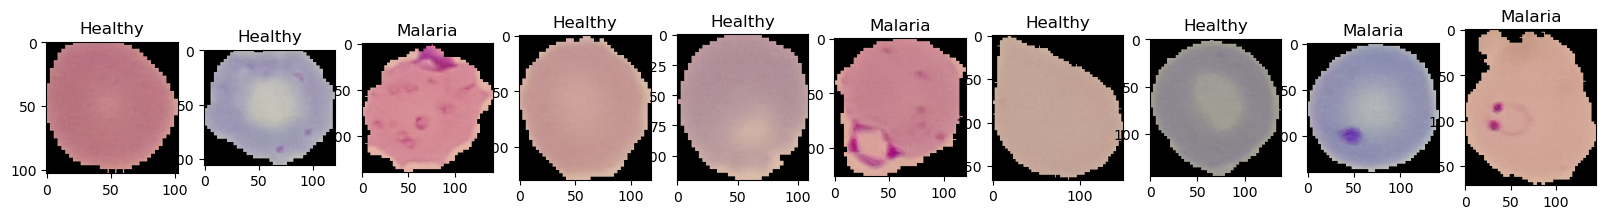

In [41]:
n_images = 10

# select some images from the dataset
images = train_ds.take(n_images)

fig, axes = plt.subplots(1, n_images, figsize=(20, 5), dpi=100)
for ax, (image, label) in zip(axes, images):
    ax.imshow(image)
    ax.set_title("Healthy" if label.numpy() == 1 else "Malaria")

<h2 style="display: inline">2. Preprocessing the dataset</h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_2"></a> 

For this dataset two preprocessing operations are required:
1. Resize all images to uniform width and height, and
2. normalize the pixel value range to [0,1].

Neural networks have a fixed architecture and can therefore only take inputs of equal dimensions. This is why we have to preprocess the images to have uniform dimensions. For the Malaria dataset, we downsample the images to be 40 pixels high and 40 pixels wide. We will need the `resize_with_pad` and `resize` functions from the `tf.image` module.

Normalization of the pixel range to a [0,1] range is done to improve the stability of the weight updates. The Malaria dataset contains 8-bit RGB images, which have a maximum pixel value of 255 and a minimum of 0. If we would train the neural network using pixel values in the [0,255] range, the network's weights could grow too large causing high values during backpropagation and unstable training.

In [11]:
# define the first preprocessing function
# note: in this function we also cast the images to the float32 data type.

image_width, image_height = 40, 40
def resize_images(image, label):
    return (
        tf.cast(tf.image.resize_with_pad(tf.image.resize(image, (image_width, image_height)), image_width, image_height), tf.float32), 
        tf.cast(label, tf.float32)
    )

In [12]:
# define the second preprocessing function
def minmax_normalization(image, label):
    return (
        image / tf.math.reduce_max(tf.reshape(image, [-1, image.shape[-1]]), axis=0), # divide each pixel in the image by the maximum value in each channel (R, G, and B)
        label
    )

<div class="alert alert-success">
<h3> Exercise</h3>
    
Apply both preprocessing functions to the train and test dataset defined earlier. Have a look at the [TensorFlow Datasets documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) to see how you can *map* a function over the elements of a dataset.
</div>

In [13]:
# apply resize images
train_ds = train_ds.map(resize_images)
test_ds = test_ds.map(resize_images)

In [14]:
# apply minmax
train_ds = train_ds.map(minmax_normalization)
test_ds = train_ds.map(minmax_normalization)

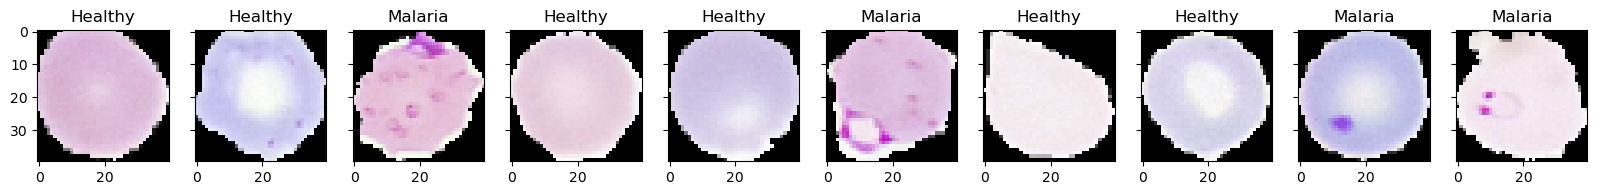

In [15]:
# have a look at the preprocessed images...

n_images = 10
fig, axes = plt.subplots(1, n_images, figsize=(20, 5), dpi=100, sharex=True, sharey=True)
for ax, (image, label) in zip(axes, train_ds.take(n_images)):
    ax.imshow(image.numpy())
    ax.set_title("Healthy" if label.numpy() == 1 else "Malaria")

The data is now preprocessed and ready to handled by the neural network that we will define in the next part.

<h2 style="display: inline">3. Implementing a neural network</h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_3"></a> 

We need a neural network that is capable of classifying cell images in a positive and negative class. In this case, we want it to distinguishing between a healthy and parasitized cell based on a 40x40 RGB image. For today's standards this specific problem is a fairly easy computer vision task. A simple (and efficient) _shallow_ convolutional neural network (CNN) will suffice.

<br>

<h3 style="display: inline">3.1 Define the architecture</h3> <a class="anchor" id="section_3_1"></a>

The neural network will consist out of 4 main layers: 2 feature extraction layers, and 2 classification layers.

The **feature extraction** layers are made up of [convolution](https://developers.google.com/static/machine-learning/practica/image-classification/images/convolution_overview.gif) and [max-pooling operations](https://developers.google.com/static/machine-learning/practica/image-classification/images/maxpool_animation.gif) and activation functions. They will learn to extract relevant features from the image and enable the classification layers to learn to classify cells into the healthy or parasitized category.

The extracted features get passed on to the **classification layers**, which are made up of densely connected layers, dropout connections and activation functions.

The [**activation functions**](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*XxxiA0jJvPrHEJHD4z893g.png) used in this neural network are the sigmoid, and Rectified Linear Unit (ReLU). The ReLU is used as the intermediate activation function in the feature extraction and classification layers. This function is used in many state-of-the-art image classification networks. It works well because it prevents the gradients from *vanishing* during backpropagation. The sigmoid is the activation function applied to the output of the final densely connected layer. It squeezes whatever value that comes out of the network to the 0-1 range. Ideal for binary classification!

![SegmentLocal](network_diagram.jpg)


<div class="alert alert-success">
<h3> Exercise</h3>
    
Define a CNN architecture with the [TensorFlow Keras API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) using the above scheme as a guideline. Feel free to try out some of your own settings! The network takes RGB images as input, and has one output neuron that will produce output values between 0 (malaria) and 1 (healthy).
    
You will need the following layers:
    <ul>
    <li> `tf.keras.layers.Conv2D`</li>
    <li> `tf.keras.layers.MaxPool2D`</li>
    <li>`tf.keras.layers.ReLU`</li>
    <li>`tf.keras.layers.Flatten`</li>
    <li>`tf.keras.layers.Dense`</li>
    <li>`tf.keras.layers.Dropout`</li>
</ul>
</div>

In [16]:
with tf.device(device):
    classifier = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=2, kernel_size=3, strides=(1,1), padding="same"),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2D(filters=2, kernel_size=3, strides=(2,2), padding="same"),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])

<h3 style="display: inline">3.2 Define the loss function, optimizer, and metrics</h3> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_3_2"></a>

To optimize the parameters of the network we need an optimization algorithm, and a loss function to minimize. In this particular case the binary cross-entropy is a good choice.

$$\textrm{BinaryCrossEntropy} = -\frac{1}{N}\sum_{i=1}^N{(y_i\cdot\log(p_i) + (1 - y_i)\cdot\log(1 - p_i))}$$

In [17]:
bce_loss = tf.keras.losses.BinaryCrossentropy()

 As optimization algorithm we choose stochastic gradient descent (SGD). More advanced optimizers exist, but SGD is a good first choice.

In [18]:
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

The binary cross-entropy is a good metric for optimization, but is less interpretable. Accuracy is a more intuitive metric for assessing model performance.
$$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$$

In [42]:
accuracy_metric = tf.keras.metrics.BinaryAccuracy()

Finally, TensorFlow requires us to `compile` all parts of the learning procedure together.

In [43]:
with tf.device(device):
    classifier.compile(optimizer=sgd_optimizer, loss=bce_loss, metrics=[accuracy_metric])

<h3 style="display: inline">3.3 Run the learning procedure to train the network</h3> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_3_3"></a>

First, we define some constants for the learning procedure.

In [21]:
epochs = 30 # How many times will the network see all training data
batch_size = 256 # How many instances will the network process in one iteration

train_len = int(builder.info.splits["train"].num_examples*0.6)
test_len = int(builder.info.splits["train"].num_examples*0.4)
steps_per_epoch = train_len//batch_size
test_steps = test_len//batch_size

Next, we iteratively update the parameters of the network using mini-batches of data (of size `batch_size`). In other words, we fit the network to the data. In pseudo-code:
```
for epoch in epochs:
    for true_labels, batch in batches:
        predictions = network(batch)
        loss = loss_function(true_labels, predictions)
        optimizer.update(network, loss)
```
The TensorFlow Keras API has several utitility functions that wrap basic procedures in helper functions. One such function is `fit` ([documentation](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#fit)). It performs something close to the above pseudo-code on our network. All we have to do, is pass it the constants we defined above. Using helper functions is good practice as it lets us write code quicker, and it is less error-prone. However, always know what the helper functions do exactly!

Note that we save the return value of the fit function to a variable. It contains important information about the performance of our network. We will analyze this in the next part.

In [22]:
with tf.device(device):
    history = classifier.fit(
        train_ds.batch(batch_size).repeat(), # on which data to we want to train
        epochs=epochs, # how many epochs do we want to run
        steps_per_epoch=steps_per_epoch, # how many steps are in one epoch
        validation_data=test_ds.batch(batch_size).repeat(), # what test data do we want to use
        validation_steps=test_steps # how many steps do we need to take when testing
    )

Epoch 1/30


2023-05-02 14:11:27.150950: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-05-02 14:11:27.994375: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 11.1).  Compilation of XLA kernels below will likely fail.

You may not need to update CUDA; cherry-picking the ptxas binary is often sufficient.
2023-05-02 14:11:27.995186: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-05-02 14:11:27.995193: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2023-05-02 14:11:27.995220: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This mes

 1/64 [..............................] - ETA: 2:40 - loss: 0.6905 - binary_accuracy: 0.5273

2023-05-02 14:11:28.430422: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 11.1).  Compilation of XLA kernels below will likely fail.

You may not need to update CUDA; cherry-picking the ptxas binary is often sufficient.
2023-05-02 14:11:28.455416: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 11.1).  Compilation of XLA kernels below will likely fail.

You may not need to update CUDA; cherry-picking the ptxas binary is often sufficient.
2023-05-02 14:11:28.560153: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 11.1).  Compilation of XLA kernels below will likely fail.

You may not need to update CUDA; cherry-picking the ptxas binary is often sufficient.


64/64 [==============================] - 4s 26ms/step - loss: 0.6891 - binary_accuracy: 0.5353 - val_loss: 0.6847 - val_binary_accuracy: 0.5550
Epoch 2/30
64/64 [==============================] - 1s 23ms/step - loss: 0.6815 - binary_accuracy: 0.5573 - val_loss: 0.6770 - val_binary_accuracy: 0.5701
Epoch 3/30
64/64 [==============================] - 1s 24ms/step - loss: 0.6761 - binary_accuracy: 0.5748 - val_loss: 0.6713 - val_binary_accuracy: 0.5823
Epoch 4/30
64/64 [==============================] - 2s 26ms/step - loss: 0.6709 - binary_accuracy: 0.5835 - val_loss: 0.6661 - val_binary_accuracy: 0.5909
Epoch 5/30
64/64 [==============================] - 2s 29ms/step - loss: 0.6656 - binary_accuracy: 0.5949 - val_loss: 0.6605 - val_binary_accuracy: 0.6014
Epoch 6/30
64/64 [==============================] - 1s 23ms/step - loss: 0.6606 - binary_accuracy: 0.6053 - val_loss: 0.6506 - val_binary_accuracy: 0.6197
Epoch 7/30
64/64 [==============================] - 1s 23ms/step - loss: 0.6551 -

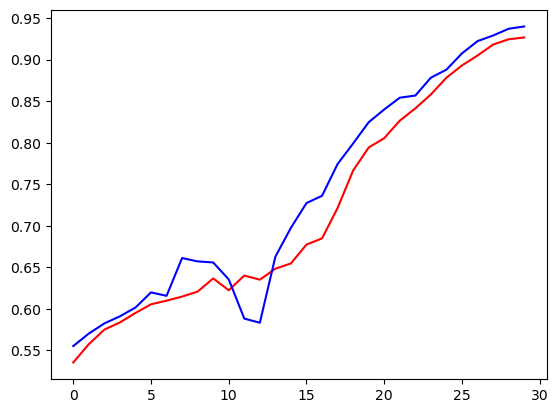

In [23]:
# plot binary_accury and val_binary_accuracy

plt.plot(history.epoch, history.history["binary_accuracy"], color="red")
plt.plot(history.epoch, history.history["val_binary_accuracy"], color="blue")

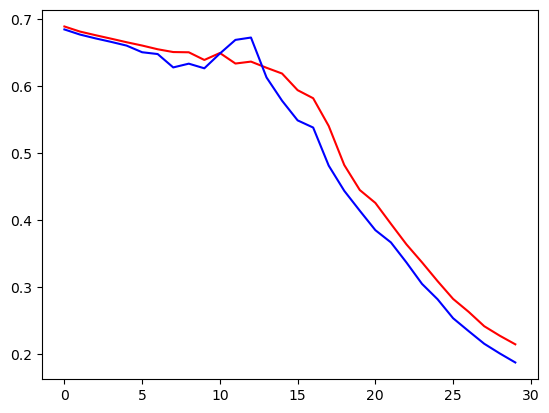

In [24]:
# plot loss and val_loss

plt.plot(history.epoch, history.history["loss"], color="red")
plt.plot(history.epoch, history.history["val_loss"], color="blue")

Note that we are using a dropout layer to improve generalization. This layer randomly shuts of connections during training. During testing, this layer is disabled and all connections are always enabled. This explains why the testing accuracy is often higher then the training accuracy, and the testing loss is often lower then the training loss.

<div class="alert alert-success">
<h3>Exercise</h3>

Many other optimizers exist besides the SGD optimizer that we used. For example, the Adam optimizer combines two extensions of SGD into one powerful optimizer. Try to use the Adam optimizer to fit the neural network. See how the training progresses - do you notice any difference compared to SGD?
    
<b>Note:</b> In order to retrain the classifier with another optimizer you have to reinstantiate the classifier.
</div>




In [25]:
with tf.device(device):
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    classifier.compile(optimizer=adam_optimizer, loss=bce_loss, metrics=[accuracy_metric])

In [26]:
with tf.device(device):
    history = classifier.fit(
        train_ds.batch(batch_size).repeat(), # on which data to we want to train
        epochs=epochs, # how many epochs do we want to run
        steps_per_epoch=steps_per_epoch, # how many steps are in one epoch
        validation_data=test_ds.batch(batch_size).repeat(), # what test data do we want to use
        validation_steps=test_steps # how many steps do we need to take when testing
    )

Epoch 1/30


2023-05-02 14:12:58.532524: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-02 14:12:58.587531: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 11.1).  Compilation of XLA kernels below will likely fail.

You may not need to update CUDA; cherry-picking the ptxas binary is often sufficient.
2023-05-02 14:12:58.647263: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 11.1).  Compilation of XLA kernels below will likely fail.

You may not need to update CUDA; cherry-picking the ptxas binary is often sufficient.
2023-05-02 14:12:58.708926: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 11.1).  Co

 1/64 [..............................] - ETA: 49s - loss: 0.1627 - binary_accuracy: 0.9400

2023-05-02 14:12:58.811262: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 11.1).  Compilation of XLA kernels below will likely fail.

You may not need to update CUDA; cherry-picking the ptxas binary is often sufficient.
2023-05-02 14:12:58.873793: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 11.1).  Compilation of XLA kernels below will likely fail.

You may not need to update CUDA; cherry-picking the ptxas binary is often sufficient.
2023-05-02 14:12:58.934854: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 11.1).  Compilation of XLA kernels below will likely fail.

You may not need to update CUDA; cherry-picking the ptxas binary is often sufficient.


64/64 [==============================] - 2s 23ms/step - loss: 0.1714 - binary_accuracy: 0.9416 - val_loss: 0.1157 - val_binary_accuracy: 0.9630
Epoch 2/30
64/64 [==============================] - 1s 22ms/step - loss: 0.1142 - binary_accuracy: 0.9609 - val_loss: 0.0876 - val_binary_accuracy: 0.9755
Epoch 3/30
64/64 [==============================] - 1s 23ms/step - loss: 0.0941 - binary_accuracy: 0.9691 - val_loss: 0.0649 - val_binary_accuracy: 0.9828
Epoch 4/30
64/64 [==============================] - 1s 23ms/step - loss: 0.0728 - binary_accuracy: 0.9771 - val_loss: 0.0516 - val_binary_accuracy: 0.9873
Epoch 5/30
64/64 [==============================] - 2s 25ms/step - loss: 0.0672 - binary_accuracy: 0.9785 - val_loss: 0.0640 - val_binary_accuracy: 0.9792
Epoch 6/30
64/64 [==============================] - 2s 29ms/step - loss: 0.0612 - binary_accuracy: 0.9803 - val_loss: 0.0348 - val_binary_accuracy: 0.9906
Epoch 7/30
64/64 [==============================] - 1s 23ms/step - loss: 0.0576 -

<h3 style="display: inline">3.4 Inspect classifier performance</h3> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_3_4"></a>

After fitting the network, we are interested in its eventual performance and how this evolved during the fitting procedure. By comparing metrics computed on the training and test dataset we can spot overfitting as well: if the training accuracy is much higher compared to testing, the network is overfitting.

The information we need, is returned by the fit function in a [`History`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History) object.

<div class="alert alert-success">
<h3>Exercise</h3>

Plot the the accuracy and loss in function of the epochs for the train and validation set. Use the `history` object returned by the `fit` function.
    
</div>

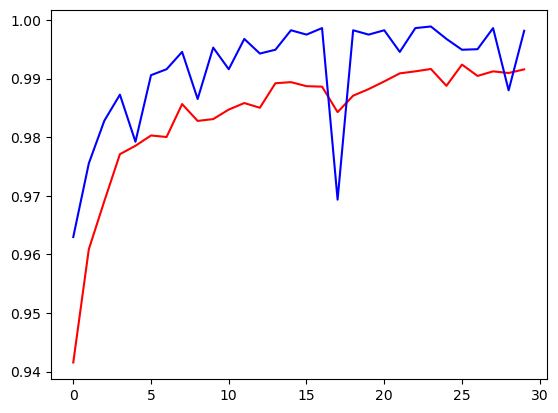

In [27]:
# plot binary_accury and val_binary_accuracy

plt.plot(history.epoch, history.history["binary_accuracy"], color="red")
plt.plot(history.epoch, history.history["val_binary_accuracy"], color="blue")

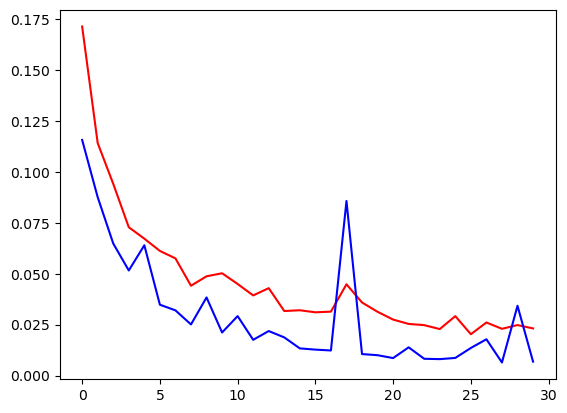

In [28]:
# plot loss and val_loss

plt.plot(history.epoch, history.history["loss"], color="red")
plt.plot(history.epoch, history.history["val_loss"], color="blue")

<div class="alert alert-success">
<h3>Exercise</h3>

Use the trained network to compute prediction scores for the test dataset. Use these scores to compute the confusion matrix and ROC AUC score.
    
</div>




In [29]:
from sklearn.metrics import confusion_matrix, roc_auc_score
true = [l.numpy() for i,l in test_ds.take(-1)]

In [30]:
scores = classifier.predict(test_ds.batch(batch_size)).ravel()

11/11 [==============================] - 0s 14ms/step


In [31]:
confusion_matrix(true, scores > 0.5)

array([[1349,    3],
       [   2, 1402]])

In [32]:
roc_auc_score(true, scores > 0.5)

0.9981782818321279

<h2 style="display: inline">Extra: A look at intermediate representations of the network</h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_4"></a> 

As an image passes through our convolutional neural network, it is transformed by the operations defined in the layers. Each transformation extracts the most relevant information from the input it receives, and passes it on to the next layer. The output of each intermediate layer is called a feature map or *representation*.

By recording these intermediate representations for an image, we get an idea of what the network is focusing on to make its prediction. This way, we get some insight into the so-called *black-box model*.

In this last part we will ook at some of the representations learned by the network we trained. Before running the code, think about what these representations might look like.

In [33]:
# extract some images to analyse
n_images = 10
it = iter(test_ds.batch(n_images))
images, labels = next(it)

# get the predictions
predictions = classifier.predict(images)

# record the intermediate representations
representations = []
record = [1, 2, 3]
x = images
for i, layer in enumerate(classifier.layers):
    x = layer(x)
    if i in record:
        representations.append(x)

1/1 [==============================] - 0s 75ms/step


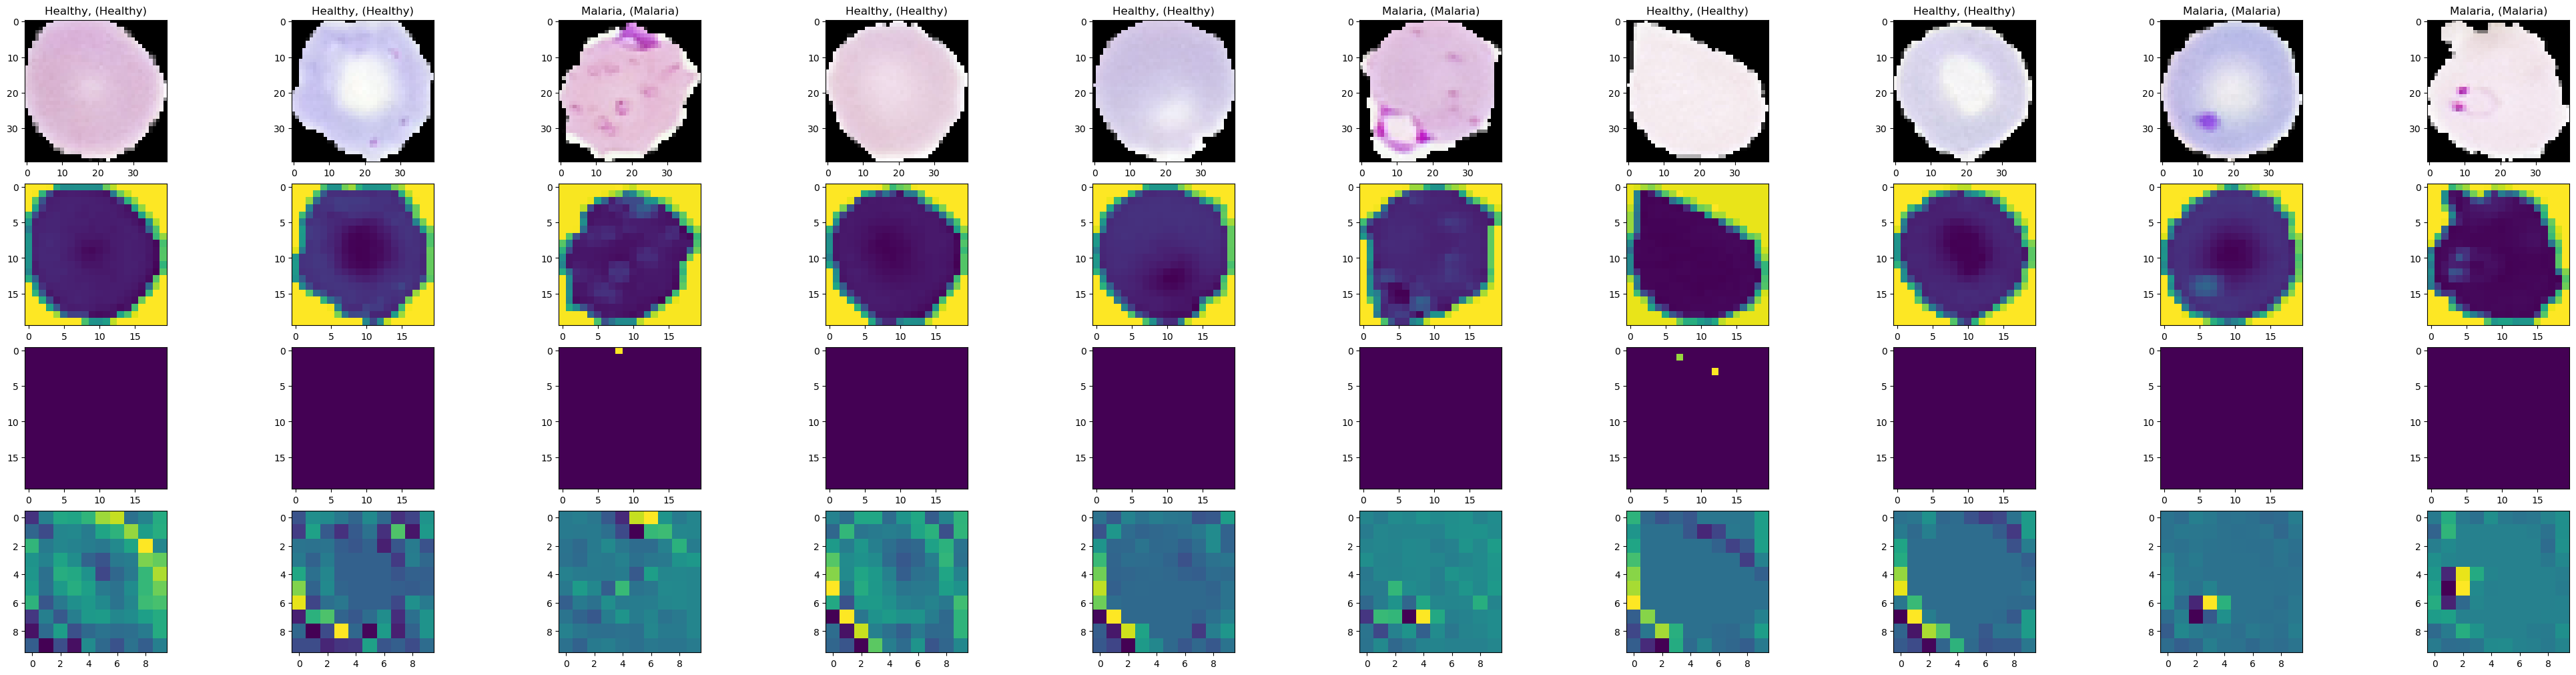

In [34]:
fig, axes = plt.subplots(1+len(representations), len(images), figsize=(40, 10), constrained_layout=True)
    
for ax,img,label,prediction in zip(axes[0, :], images, labels, predictions):
    ax.imshow(img)
    txt_label = "Healthy" if label.numpy() == 1 else "Malaria"
    txt_pred = "Healthy" if prediction > 0.5 else "Malaria"
    ax.set_title(f"{txt_label}, ({txt_pred})")
    
for reps, row in zip(representations, axes[1:, :]):
    for rep, ax in zip(reps, row):
        ax.imshow(rep[..., 0])